**Part 1 Vanishing Gradients**

In [ ]:
!unzip DATASET.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/test/n07871810/n07871810_248.JPEG  
  inflating: DATASET/test/n07871810/n07871810_255.JPEG  
  inflating: DATASET/test/n07871810/n07871810_267.JPEG  
  inflating: DATASET/test/n07871810/n07871810_268.JPEG  
  inflating: DATASET/test/n07871810/n07871810_269.JPEG  
  inflating: DATASET/test/n07871810/n07871810_27.JPEG  
  inflating: DATASET/test/n07871810/n07871810_270.JPEG  
  inflating: DATASET/test/n07871810/n07871810_28.JPEG  
  inflating: DATASET/test/n07871810/n07871810_290.JPEG  
  inflating: DATASET/test/n07871810/n07871810_291.JPEG  
  inflating: DATASET/test/n07871810/n07871810_294.JPEG  
  inflating: DATASET/test/n07871810/n07871810_301.JPEG  
  inflating: DATASET/test/n07871810/n07871810_305.JPEG  
  inflating: DATASET/test/n07871810/n07871810_310.JPEG  
  inflating: DATASET/test/n07871810/n07871810_315.JPEG  
  inflating: DATASET/test/n07871810/n07871810_317.JPEG  
  inflating: DATASET/test/n07871810/n07

In [59]:
import os
os.listdir()

['.config', 'DATASET', 'DATASET.zip', 'sample_data']

In [60]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda")
print(device)

cuda


In [61]:
# Transforming images to 64 X 64 size
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [62]:
# Loading the Data
train_path = "/content/DATASET/train"
val_path   = "/content/DATASET/val"

train_set = datasets.ImageFolder(train_path, transform)
val_set   = datasets.ImageFolder(val_path, transform)

print(f"Classes: {train_set.classes}")
print(f"Total classes: {len(train_set.classes)}")

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64)

Classes: ['n07871810', 'n07873807', 'n07875152', 'n07920052', 'n09193705', 'n09246464', 'n09256479', 'n09332890', 'n09428293', 'n12267677']
Total classes: 10


In [63]:
# Defining The models with a total of 9 layers

class DeepSigmoid(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Flatten(),

            nn.Linear(64*64*3,512),
            nn.Sigmoid(),

            nn.Linear(512,512),
            nn.Sigmoid(),

            nn.Linear(512,512),
            nn.Sigmoid(),

            nn.Linear(512,512),
            nn.Sigmoid(),

            nn.Linear(512,512),
            nn.Sigmoid(),

            nn.Linear(512,512),
            nn.Sigmoid(),

            nn.Linear(512,512),
            nn.Sigmoid(),

            nn.Linear(512,512),
            nn.Sigmoid(),

            nn.Linear(512,10)
        )

    def forward(self,x):
        return self.net(x)


class DeepReLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Flatten(),

            nn.Linear(64*64*3,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,10)
        )

    def forward(self,x):
        return self.net(x)





In [64]:
def train(model, lr=0.001, optimizer_type="adam"):
    model.to(device)

    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    loss_fn = nn.CrossEntropyLoss()

    grad_norms = []

    for epoch in range(10):
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out,y)
            loss.backward()

            first_layer = list(model.parameters())[0]
            grad_norms.append(first_layer.grad.norm().item())

            optimizer.step()

    return grad_norms


In [65]:
def accuracy(model):
    model.eval()
    correct,total = 0,0

    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)

    return correct/total


In [66]:
sig = DeepSigmoid()
relu = DeepReLU()

t_sig = train(sig)

t_relu = train(relu)


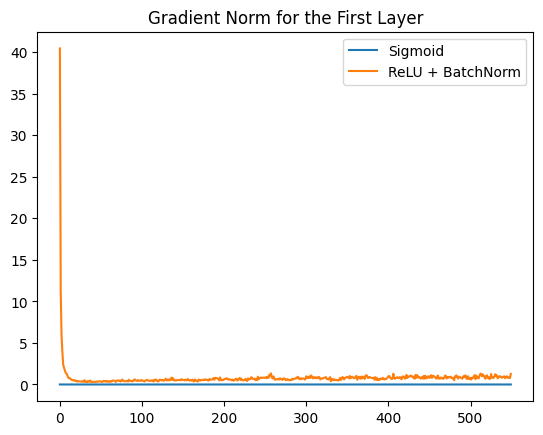

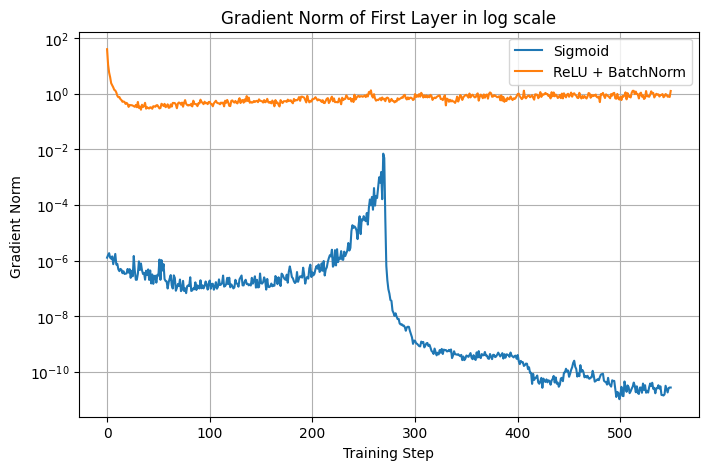

In [67]:
plt.plot(t_sig,label="Sigmoid")
plt.plot(t_relu,label="ReLU + BatchNorm")
plt.legend()
plt.title("Gradient Norm for the First Layer")

plt.figure(figsize=(8,5))

plt.plot(t_sig, label="Sigmoid")
plt.plot(t_relu, label="ReLU + BatchNorm")

plt.yscale("log")

plt.xlabel("Training Step")
plt.ylabel("Gradient Norm ")
plt.title("Gradient Norm of First Layer in log scale")
plt.legend()
plt.grid(True)

plt.show()


In [54]:
print("Sigmoid Accuracy:", accuracy(sig))
print("ReLU Accuracy:", accuracy(relu))


Sigmoid Accuracy: 0.1
ReLU Accuracy: 0.368


**PART - 2 Ablation study**

In [68]:
class DeepNN(nn.Module):
    def __init__(self, use_bn=True, use_dropout=True):
        super().__init__()

        layers = [nn.Flatten()]

        layers.append(nn.Linear(64*64*3,512))
        if use_bn:
            layers.append(nn.BatchNorm1d(512))
        layers.append(nn.ReLU())
        if use_dropout:
            layers.append(nn.Dropout(0.5))

        for _ in range(7):
            layers.append(nn.Linear(512,512))
            if use_bn:
                layers.append(nn.BatchNorm1d(512))
            layers.append(nn.ReLU())
            if use_dropout:
                layers.append(nn.Dropout(0.5))

        layers.append(nn.Linear(512,10))

        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)



In [69]:
def train_NN(model, lr=0.001, optimizer_type="adam", epochs=10):
    model.to(device)

    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out,y)
            loss.backward()
            optimizer.step()

    return accuracy(model)



In [70]:
results = {}

baseline = DeepNN(use_bn=True, use_dropout=True)
results["Baseline"] = train_NN(baseline)

no_dropout =  DeepNN(use_bn=True, use_dropout=False)
results["No Dropout"] = train_NN(no_dropout)

learning_rates = [0.0001,1000]

for lr in learning_rates:
    model = DeepNN(use_bn=True, use_dropout=True)
    results[f"LR={lr}"] = train_NN(model, lr=lr)

sgd_model =  DeepNN(use_bn=True, use_dropout=True)
results["SGD"] = train_NN(sgd_model, optimizer_type="sgd")



In [71]:
print("\nABLATION RESULTS\n")

for key,value in results.items():
    print(f"{key:} → {value:.3f}")




ABLATION RESULTS

Baseline → 0.388
No Dropout → 0.336
LR=0.0001 → 0.100
LR=1000 → 0.100
SGD → 0.108
